<a href="https://colab.research.google.com/github/HHL43/Generative-AI-HW/blob/main/AI_hw02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 以Gradio進行手寫數字辯識
* 使用CNN+Dense當模型
* loss function使用categorical_crossentropy
* optimizer使用adamW
* ImageDataGenerator做Data Augmentation

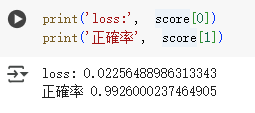

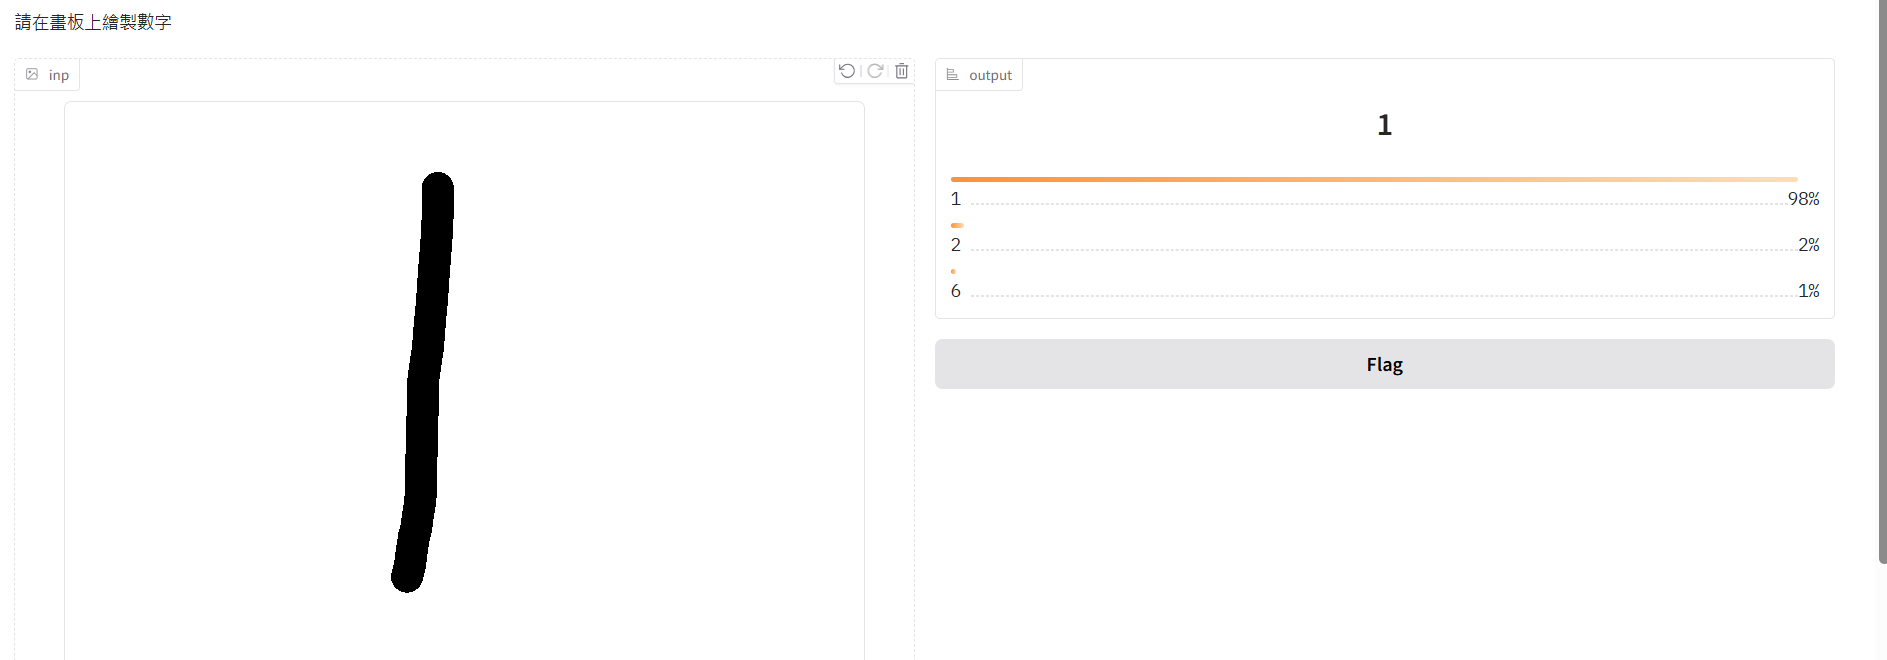

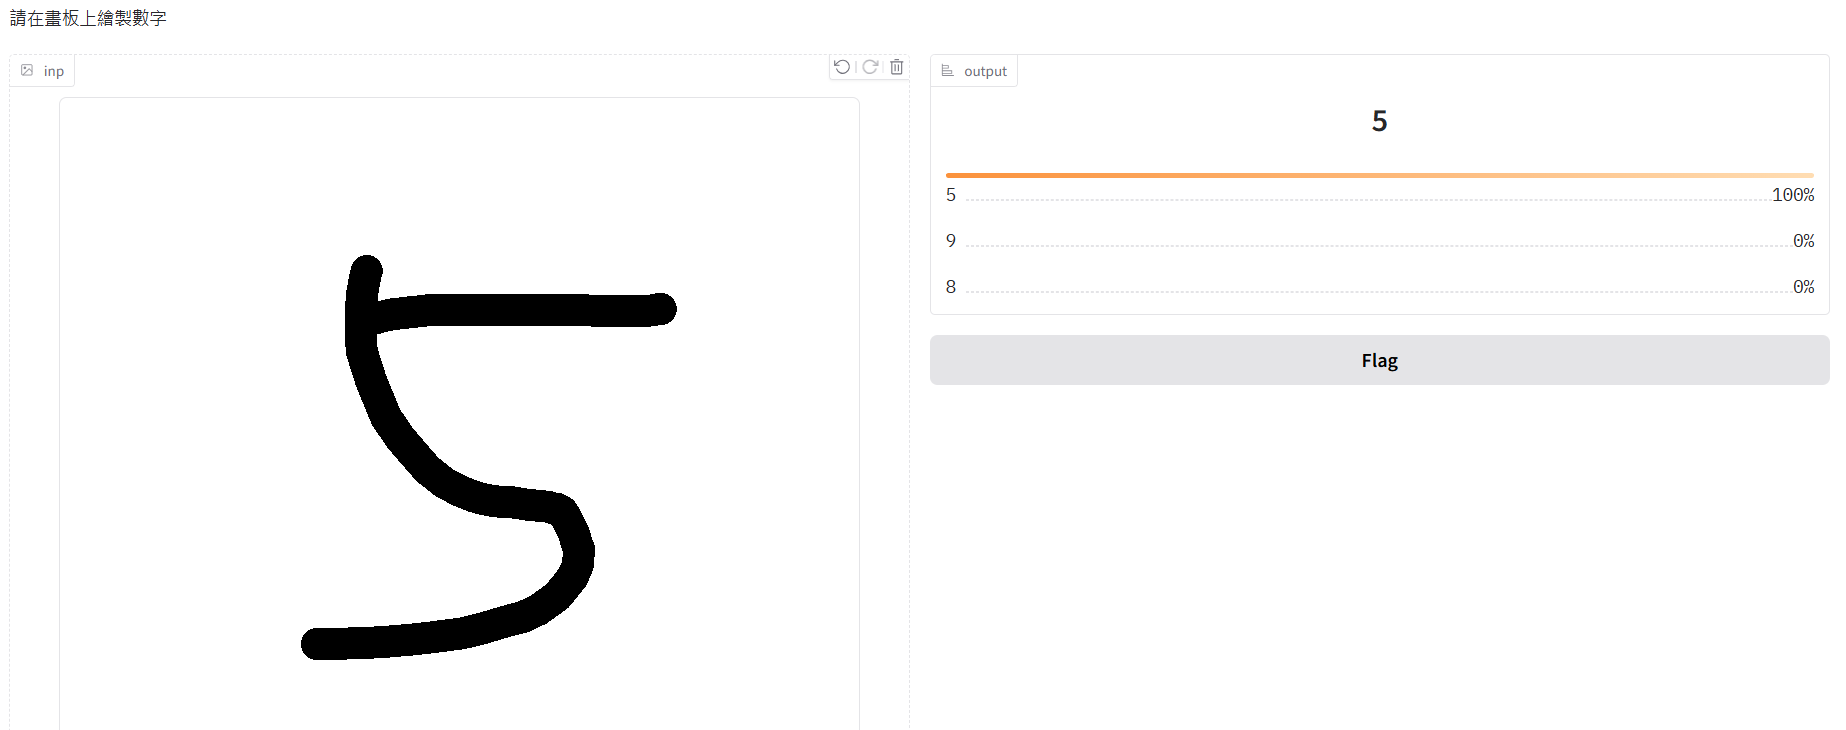

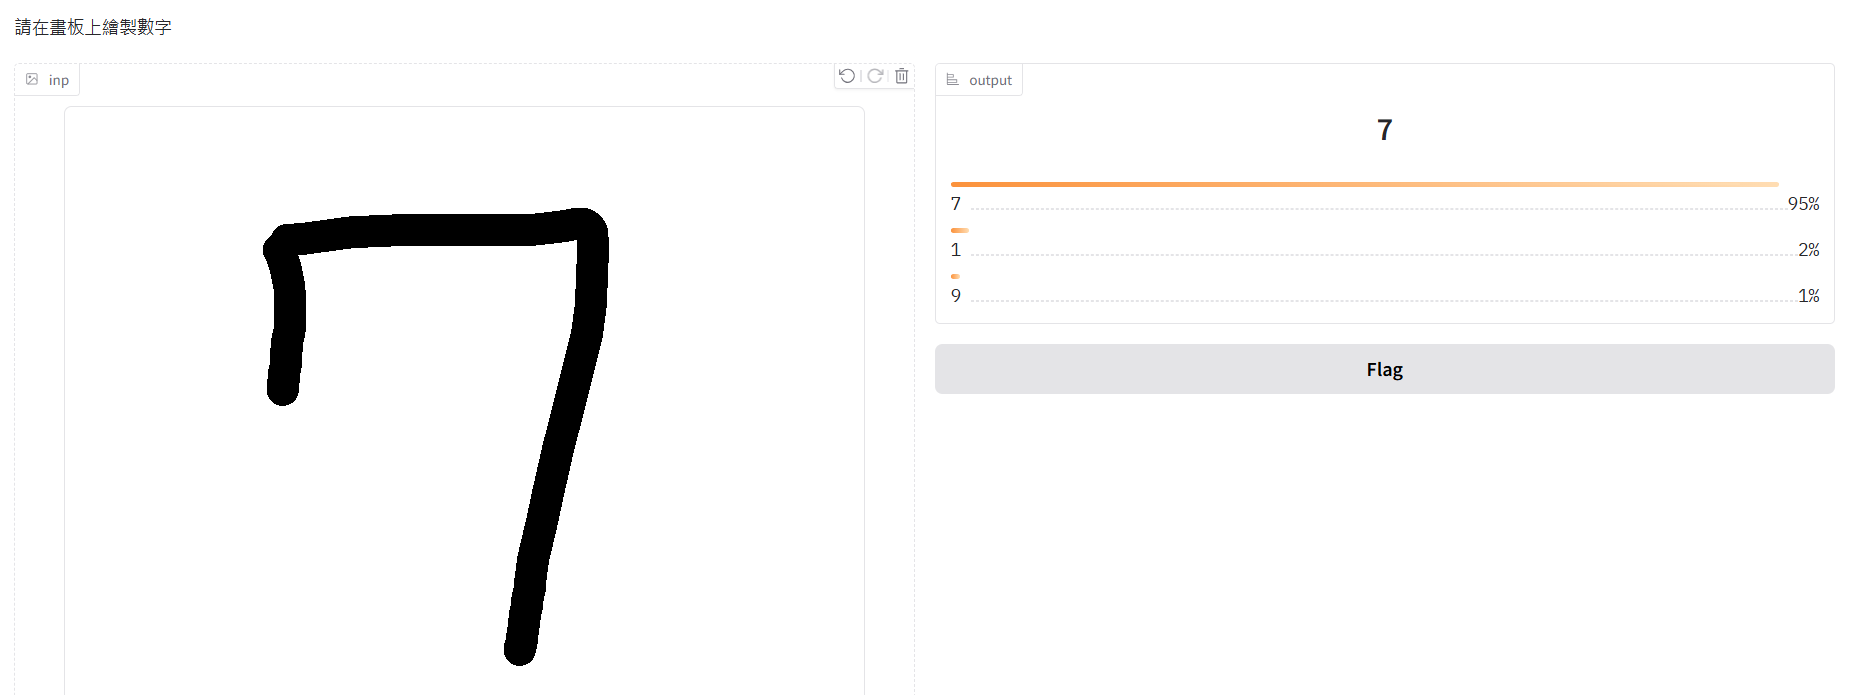

In [1]:
!pip install gradio

In [2]:
%matplotlib inline

# 標準數據分析、畫圖套件
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 神經網路方面
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 互動設計用
from ipywidgets import interact_manual

# 神速打造 web app 的 Gradio
import gradio as gr

* 除以255用途: 把像素值歸一化到0~1之間，這樣可以：1.提升神經網路訓練效率（避免數值過大影響梯度下降）。2.讓模型收斂更快、更穩定。
* 增加維度: 因為Conv2D（卷積層）需要三維影像輸入（高度,寬度,通道數），但MNIST原本是二維矩陣(28, 28)，缺少通道數維度，所以要用np.expand_dims()來增加一個 1 的維度，讓形狀變成(28, 28, 1)。axis=-1 代表在最後一個維度上增加一個維度，這樣每張圖片現在都有一個單通道（1），代表灰階影像，符合Conv2D層的輸入需求

In [3]:
# 載入 MNIST 數據集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28, 28)/255
x_test = x_test.reshape(10000, 28, 28)/255
x_train = np.expand_dims(x_train, axis=-1)  # (60000, 28, 28) → (60000, 28, 28, 1) 增加維度
x_test = np.expand_dims(x_test, axis=-1)

# 將label轉換為 one-hot 編碼
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

#預覽
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

* Sequential()：表示這是一個線性堆疊的模型，每一層的輸出會直接變成下一層的輸入。常用在CNN、MLP、LSTM
* MaxPooling2D作用：降低影像尺寸，減少計算量，保留重要特徵。
* pool_size=(2,2)：每2×2的區域取最大值，使圖像尺寸縮小。



In [4]:
model = Sequential()

# 定義輸入層
model.add(Input(shape=(28,28,1)))

# 第一個卷積層：32 個 3×3 Filters
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

# 池化層（降低維度）
model.add(MaxPooling2D(pool_size=(2,2)))

# 第二個卷積層：64 個 3×3 Filters
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

# 再次池化
model.add(MaxPooling2D(pool_size=(2,2)))

# 展平成向量後，進入全連接層
model.add(Flatten())

# 全連接層
model.add(Dense(128, activation='relu'))

# 輸出層（10個類別分類）
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

* loss='categorical_crossentropy'：使用one-hot編碼標籤，可以選擇這個損失函數。
* optimizer='adam': 這是進行數字圖形辨識時最推薦的優化器，適合各種場景，並且對學習率的選擇較為不敏感。
* learning_rate=0.001（對於 Adam 優化器）：Adam 優化器通常在 learning_rate=0.001 下表現良好，這是深度學習中經常選擇的默認學習率。

In [6]:
# 編譯模型
model.compile(loss='categorical_crossentropy', optimizer=AdamW(learning_rate=0.001), metrics=['accuracy'])

# 建立數據增強的 ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,       # 隨機旋轉 -15 到 +15 度
    width_shift_range=0.1,   # 水平移動 10%
    height_shift_range=0.1,  # 垂直移動 10%
    zoom_range=0.1,         # 隨機縮放 10%
    horizontal_flip=False,    # 水平翻轉
    shear_range=0.1,        # 剪切變換
    fill_mode="nearest"     # 補充缺失像素的方式
)

# 訓練數據增強
train_generator = datagen.flow(x_train, y_train, batch_size=100, shuffle=True)

# 訓練模型
model.fit(train_generator,
          epochs=10,
          validation_data=(x_test, y_test),
          steps_per_epoch=len(x_train) // 100)  # 確保完整訓練


Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.9507 - loss: 0.1557 - val_accuracy: 0.9847 - val_loss: 0.0451
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.9704 - loss: 0.0959 - val_accuracy: 0.9899 - val_loss: 0.0294
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9788 - loss: 0.0689 - val_accuracy: 0.9909 - val_loss: 0.0288
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9815 - loss: 0.0599 - val_accuracy: 0.9903 - val_loss: 0.0293
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.9831 - loss: 0.0555 - val_accuracy: 0.9918 - val_loss: 0.0254
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9836 - loss: 0.0529 - val_accuracy: 0.9925 - val_loss: 0.0265
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.9865 - loss: 0.0429 - val_accuracy: 0.9926 - val_loss: 0.0224
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9882 - loss: 0.0394 - 

In [7]:
#評估模型
loss, acc = model.evaluate(x_test, y_test)
print(f"測試資料正確率 {acc*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9906 - loss: 0.0269
測試資料正確率 99.26%


In [8]:
#進行預測
predict = np.argmax(model.predict(x_test), axis=-1)
predict

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([7, 2, 1, ..., 4, 5, 6])

### 定義測試函數，顯示圖像和預測結果

In [10]:
def test(測試編號):
    plt.imshow(x_test[測試編號].reshape(28,28), cmap='Greys')
    print('神經網路判斷為:', predict[測試編號])

In [11]:
interact_manual(test, 測試編號=(0, 9999));

interactive(children=(IntSlider(value=4999, description='測試編號', max=9999), Button(description='Run Interact', …

In [12]:
score = model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9906 - loss: 0.0269


In [13]:
print('loss:', score[0])
print('正確率', score[1])

loss: 0.02256488986313343
正確率 0.9926000237464905


### 用 Gradio 來展示

In [14]:
def resize_image(inp):
    # 圖在 inp["layers"][0]
    image = np.array(inp["layers"][0], dtype=np.float32)
    image = image.astype(np.uint8)

    # 轉成 PIL 格式
    image_pil = Image.fromarray(image)

    # Alpha 通道設為白色, 再把圖從 RGBA 轉成 RGB
    background = Image.new("RGB", image_pil.size, (255, 255, 255))
    background.paste(image_pil, mask=image_pil.split()[3]) # 把圖片粘貼到白色背景上，使用透明通道作為遮罩
    image_pil = background

    # 轉換為灰階圖像
    image_gray = image_pil.convert("L")

    # # 將灰階圖像縮放到 28x28, 轉回 numpy array
    img_array = np.array(image_gray.resize((28, 28), resample=Image.LANCZOS))

    # 配合 MNIST 數據集
    img_array = 255 - img_array

    # 拉平並縮放
    img_array = img_array.reshape(1, 28, 28, 1) / 255.0

    return img_array

In [15]:
def recognize_digit(inp):
    img_array = resize_image(inp)
    prediction = model.predict(img_array).flatten()
    labels = list('0123456789')
    return {labels[i]: float(prediction[i]) for i in range(10)}

In [16]:
iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST 手寫辨識",
    description="請在畫板上繪製數字"
)

iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://acda1f6dc3dd862c52.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://acda1f6dc3dd862c52.gradio.live
